In [1]:
%load_ext autoreload
%autoreload 2

# Human Tonsil (SlideTags)

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys 
import commot as ct

sys.path.append('../../src')
sys.path.append('..')

from spaceoracle.tools.network import expand_paired_interactions
from spaceoracle.tools.network import get_human_housekeeping_genes
from spaceoracle.oracles import BaseTravLR
from spaceoracle.tools.network import encode_labels
from spaceoracle.tools.utils import scale_adata

import celloracle as co

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
# Human Tonsil snRNAseq from SlideTags
# https://www.nature.com/articles/s41586-023-06837-4



adata = sc.read_h5ad('/Users/koush/Downloads/slidetags_human_tonsil/human_tonsil.h5ad')
adata = adata[:, [gene for gene in adata.var_names if not bool(re.search(r'\.\d+$', gene))]]
del adata.uns
adata = scale_adata(adata, cell_size=10)
adata

AnnData object with n_obs × n_vars = 5778 × 19171
    obs: 'cell_type'
    obsm: 'spatial', 'spatial_unscaled'

<Axes: ylabel='cell_type'>

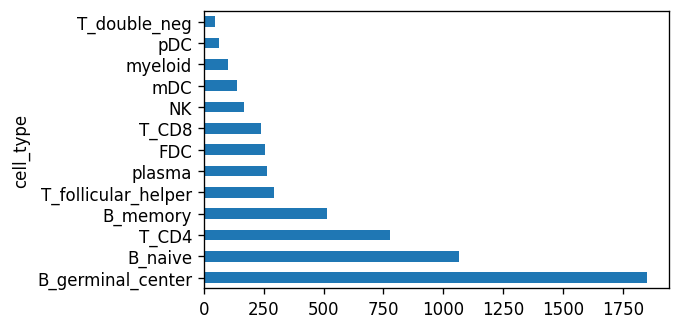

In [69]:
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 120

adata.obs.cell_type.value_counts().plot(kind='barh')

In [70]:
base_GRN = co.data.load_human_promoter_base_GRN()

extra_genes = np.unique(['FOXO1', 'BATF', 'BACH2', 'PRDM1', 'BCL6', 'FOXP3', 'SATB1', 'ID2', 'PAX5', 
    'CXCR4', 'CD83', 'CD86', 'AICDA', 'BCL2A1', 'BCL2', 'LMO2', 'CXCL13', 
    'CD80', 'TRAF3', 'CCL19', 'CCR7', 'CCL21', 'CD40LG', 'CD40', 'IRF4', 'IRF8', 
    'ITGA5', 'ITGB1', 'ITGAM', 'ITGB2', 'CCR6', 'CD19', 
    'BCL2', 'IL2', 'IL4', 'CD83', 'CD86', 'SDF4', 'SDF2', 'SDF2L1', 
    'S1PR1', 'BMS1P14', 'S1PR3', 'S1PR4', 'S1PR2', 'EBI3', 'CD28', 
    'MICOS10', 'ICOS', 'MICOS13', 'ICOSLG', 'PDCD11', 'PDCD1', 'CD274', 
    'PDCD1LG2', 'TICAM2', 'ICAM2', 'TICAM1', 'EPCAM', 'ICAM1', 'ICAM3', 
    'VCAM1', 'CXCR4', 'CXCR5',  'CXCL13', 'CXCL14', 'CXCL12', 'CR2', 'NFKBIZ', 
    'NFKB1', 'NFKBIL1', 'NFKBIE', 'NFKB2', 'NFKBIA', 'NFKBID', 'NFKBIB', 
    'IL6R', 'IL6ST', 'EGR1', 'EGR3', 'EGR2', 'GATA3', 'TBX21', 'STAT3', 
    'STAT1', 'STAT4', 'STAT6', 'IL4', 'IL6ST', 'IL6', 'IL17A'])

len(extra_genes)

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


84

In [71]:
df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='human', 
        signaling_type="Secreted Signaling"
    )
            
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']
df_ligrec = expand_paired_interactions(df_ligrec)

coms_df =df_ligrec.query('receptor.str.contains("CXCR") or ligand.str.contains("CXCL")')
genes_of_interest = list(np.unique(coms_df.ligand.unique().tolist() + \
                         coms_df.receptor.unique().tolist()))
genes_of_interest = genes_of_interest + list(extra_genes)
len(genes_of_interest)

108

In [72]:
housekeeping_db = get_human_housekeeping_genes()

In [73]:
n_top_genes = 3500
min_cells = 10
min_counts = 100

In [74]:
adata = adata[:, ~adata.var_names.str.contains('RIK')]
adata = adata[:, ~adata.var_names.str.contains(r'^HB\w+-\w+$')]
adata = adata[:, ~adata.var_names.str.contains('HP')]
adata = adata[:, ~adata.var_names.str.startswith('RP')]
adata = adata[:, ~adata.var_names.str.startswith('AA')]
adata = adata[:, ~adata.var_names.str.startswith('AB')]
adata = adata[:, ~adata.var_names.str.startswith('AC')]
adata = adata[:, ~adata.var_names.str.startswith('GM')]
adata = adata[:, ~adata.var_names.str.startswith('MIR')]
adata = adata[:, ~adata.var_names.str.startswith('TTT')]
adata = adata[:, ~adata.var_names.str.startswith('LINC')]
adata = adata[:, ~adata.var_names.str.endswith('-AS1')]

In [75]:
adata.var_names_make_unique()
adata.var["MT"] = adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(adata, qc_vars=["MT"], inplace=True)
sc.pp.filter_cells(adata, min_counts=min_counts)
adata = adata[adata.obs["pct_counts_MT"] < 20].copy()
adata = adata[:, ~adata.var["MT"]]
adata = adata[:, ~adata.var_names.isin(housekeeping_db['Gene.name'].unique())]

sc.pp.filter_genes(adata, min_cells=min_cells)
sc.pp.highly_variable_genes(
    adata, flavor="seurat", n_top_genes=n_top_genes)

adata = adata[:, (adata.var.highly_variable | adata.var_names.isin(genes_of_interest))]

adata.layers["normalized_count"] = adata.to_df().values.copy()
adata

AnnData object with n_obs × n_vars = 5778 × 3549
    obs: 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'spatial'
    layers: 'normalized_count'

In [76]:
for key in ['n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_MT',
       'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts']:
    if key in adata.obs.keys():
        adata.obs.pop(key)

for key in ['MT', 'RP', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
       'n_cells', 'highly_variable', 'means', 'dispersions',
       'dispersions_norm']:
    if key in adata.var.keys():
        adata.var.pop(key)

del adata.uns

In [80]:
adata.obs['author_cell_type'] = adata.obs['cell_type'].copy()

In [82]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_int'] = adata.obs['cell_type'].apply(
    lambda x: encode_labels(adata.obs['cell_type'], reverse_dict=True)[x])

In [83]:
adata

AnnData object with n_obs × n_vars = 5778 × 3549
    obs: 'cell_type', 'author_cell_type', 'cell_type_int'
    obsm: 'spatial'
    layers: 'normalized_count'

In [84]:
pcs = BaseTravLR.perform_PCA(adata)
BaseTravLR.knn_imputation(adata, pcs, method='MAGIC')

Calculating MAGIC...
  Running MAGIC on 5778 cells and 3549 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 12.21 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.09 seconds.
    Calculating affinities...
    Calculated affinities in 1.71 seconds.
  Calculated graph and diffusion operator in 16.03 seconds.
  Calculating imputation...
  Calculated imputation in 0.61 seconds.
Calculated MAGIC in 16.66 seconds.


In [87]:
adata

AnnData object with n_obs × n_vars = 5778 × 3549
    obs: 'cell_type', 'author_cell_type', 'cell_type_int'
    obsm: 'spatial'
    layers: 'normalized_count', 'imputed_count'

In [88]:
adata.write_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')